In [1]:
import torch.nn as nn
import torch

from torchvision import transforms
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt


class UNet(nn.Module):
    def __init__(self, kernel, num_filters, num_colours=3, num_in_channels=1):
        super().__init__()

        # Useful parameters
        stride = 2
        padding = kernel // 2
        output_padding = 1

        self.downconv1 = nn.Sequential(
            nn.Conv2d(num_in_channels, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.Conv2d(num_filters, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.downconv2 = nn.Sequential(
            nn.Conv2d(num_filters, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU(),
            nn.Conv2d(num_filters*2, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.rfconv = nn.Sequential(
            nn.Conv2d(num_filters*2, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU(),
        )

        self.upconv1 = nn.Sequential(
            nn.ConvTranspose2d(num_filters*4, num_filters, kernel_size=kernel, stride=stride, padding=padding, output_padding=output_padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.Conv2d(num_filters, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
        )
        self.upconv2 = nn.Sequential(
            nn.ConvTranspose2d(num_filters*2, num_colours, kernel_size=kernel, stride=stride, padding=padding, output_padding=output_padding),
            nn.BatchNorm2d(num_colours),
            nn.ReLU(),
        )
        self.finalconv = nn.Conv2d(num_colours, num_colours, kernel_size=kernel, padding=padding)

    def forward(self, x):
        x1 = self.downconv1(x)
        x2 = self.downconv2(x1)
        x3 = self.rfconv(x2)
        x4 = self.upconv1(torch.cat([x3, x2], 1))
        x5 = self.upconv2(torch.cat([x4, x1], 1))
        out = self.finalconv(x5)
        return out


def visualize_images(original, greyscale, colorized):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    axes[0].imshow(original)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    axes[1].imshow(greyscale, cmap='gray')
    axes[1].set_title('Grayscale Image')
    axes[1].axis('off')
    
    axes[2].imshow(colorized)
    axes[2].set_title('Colorized Image')
    axes[2].axis('off')

    plt.show()



# Replace with the values you used when training the model
kernel_size = 3  # Example value
num_filters_value = 32  # Example value


# Step 1: Load your trained model
model_path = 'outputs/colourization_gan/final_model_regression_20231103212022_Generator_colourization_gan.pth'  # Replace with your .pth file path
model = UNet(kernel_size,num_filters_value )  # Replace with your model class
model.load_state_dict(torch.load(model_path))


model.eval()  # Set the model to evaluation mode

# Step 2: Define the image preprocessing
# These transforms will need to match the ones you used during training
preprocess = transforms.Compose([
    transforms.Resize(256),  # Example, adjust to your needs
    transforms.CenterCrop(224),  # Example, adjust to your needs
    transforms.ToTensor(),
    # You might need normalization if you used it during training
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


/Users/aordorica/miniforge3/envs/pytorch_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


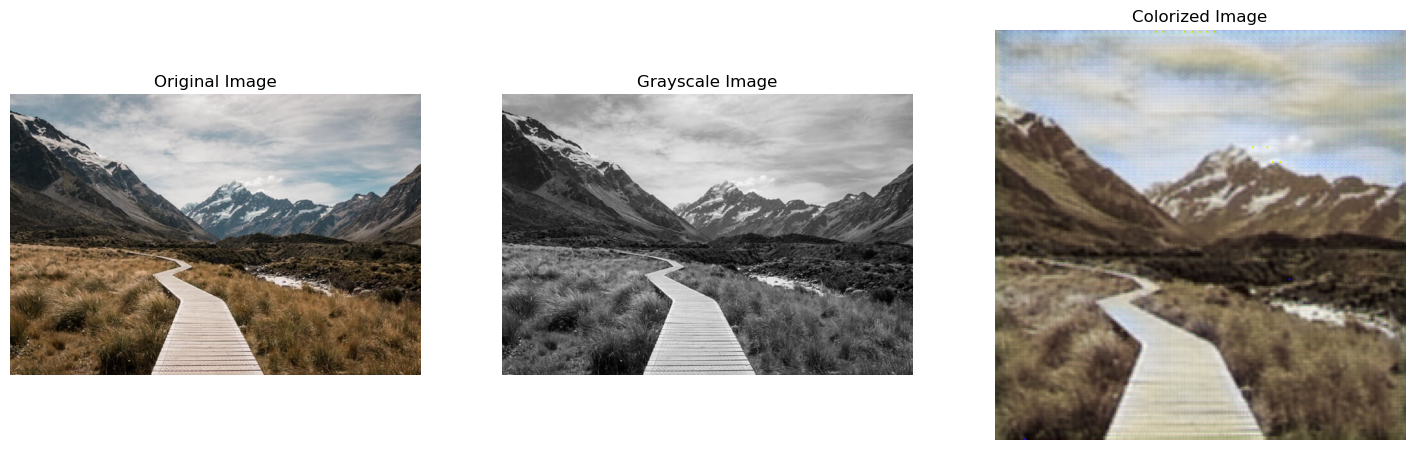

In [2]:
#Load and process the image
url = 'https://onlinejpgtools.com/images/examples-onlinejpgtools/mountain-scene.jpg'
response = requests.get(url)
original_image = Image.open(BytesIO(response.content))
greyscale_image = original_image.convert('L')

# Apply the preprocess to the greyscale image
input_tensor = preprocess(greyscale_image)
input_batch = input_tensor.unsqueeze(0)  # Create a mini-batch as expected by the model

# Run the model and get the colorized image
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # No need to track gradients for inference
    output = model(input_batch)

# Convert the output tensor to an image
output_image = output.squeeze().cpu().detach()
output_image = transforms.ToPILImage()(output_image)

# Visualize the images side by side
visualize_images(original_image, greyscale_image, output_image)
